In [1]:
# 95% overlap
# shorten window (2s)
# remove test-train split

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pywt
from scipy import signal


## Load data

In [3]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((IDD, TDC))
Y = [0]*len(TDC) + [1]*len(IDD)
Y = np.asarray(Y)

In [4]:
X = np.asarray(X)
Y = np.asarray(Y)


In [5]:
print(X.shape)
print(Y.shape)

(3220, 14, 640)
(3220,)


## Create Spectrograms

In [6]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, start_sec, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''

    downsample = int(round(Hz / hz))
    X = x[start_sec * Hz: (start_sec + num_secs) * Hz : downsample]

    t, dt = np.linspace(start_sec, start_sec + num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [7]:
def generate_scalogram(data):
    scalogram_data = []
    for sample in data:
        scalograms = []
        for channel in sample:
            scalograms.append(scalogram(channel, 128, 64, 0, 5))
        scalogram_data.append(np.concatenate(scalograms))
    return np.asarray(scalogram_data)

In [8]:
X_scalogram = generate_scalogram(X)

In [9]:
X_scalogram.shape

(3220, 448, 320)

In [10]:
# reshape data
X_scalogram = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram.shape

(3220, 448, 320, 1)

## Test-Train split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scalogram, Y, test_size=0.2, random_state=22)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1932, 448, 320, 1)
y_train shape: (1932,)
X_val shape: (644, 448, 320, 1)
y_val shape: (644,)
X_test shape: (644, 448, 320, 1)
y_test shape: (644,)


## Model

In [14]:
model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=(448, 320, 1)),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [15]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 320, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 160, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 160, 8)       32        
_________________________________________________________________
flatten (Flatten)            (None, 286720)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 286721    
Total params: 286,833
Trainable params: 286,817
Non-trainable params: 16
_________________________________________________________________


In [17]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 1932 samples, validate on 644 samples
Epoch 1/10
1932/1932 [==============================] - 95s 49ms/sample - loss: 1.1769 - accuracy: 0.8333 - val_loss: 0.3146 - val_accuracy: 0.9814
Epoch 2/10
1932/1932 [==============================] - 106s 55ms/sample - loss: 0.0334 - accuracy: 0.9964 - val_loss: 9.4816 - val_accuracy: 0.7748
Epoch 3/10
1932/1932 [==============================] - 114s 59ms/sample - loss: 0.0026 - accuracy: 0.9990 - val_loss: 9.0687 - val_accuracy: 0.7624
Epoch 4/10
1932/1932 [==============================] - 135s 70ms/sample - loss: 0.0028 - accuracy: 0.9990 - val_loss: 4.9206 - val_accuracy: 0.8230
Epoch 5/10
1932/1932 [==============================] - 118s 61ms/sample - loss: 4.6628e-05 - accuracy: 1.0000 - val_loss: 2.9516 - val_accuracy: 0.8773
Epoch 6/10
1932/1932 [==============================] - 129s 67ms/sample - loss: 7.2761e-06 - accuracy: 1.0000 - val_loss: 1.9907 - val_accuracy: 0.8960
Epoch 7/10
1932/1932 [==============================

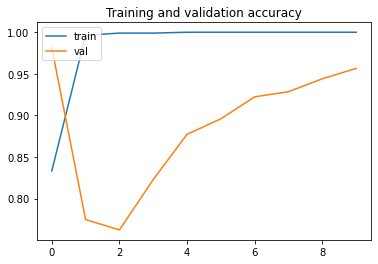

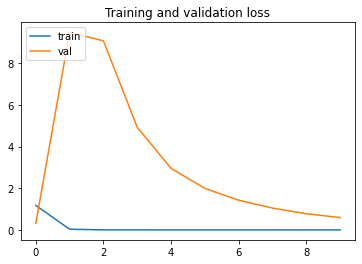

In [18]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')


plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

644/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy: 0.95341617
Test loss: 0.6424086706994675


## Other functions

In [20]:
import pywt

def wavelet_coefs(data,func, wavelet_name='db4'):
    coefs = pywt.wavedec(data, wavelet=wavelet_name, level=None)
    n_channels, n_times = data.shape
    levdec = len(coefs) - 1

    wavelet_energy = np.zeros((n_channels, levdec))
    for j in range(n_channels):
        for l in range(levdec):
            if func=='energy':
                wavelet_energy[j, l] = np.sum(coefs[levdec - l][j, :] ** 2)
            else:
                wavelet_energy[j, l] = func(coefs[levdec - l][j, :])
    return wavelet_energy.ravel()

In [21]:
def calculate_features(func):
    features1=[]
    features2=[]
    for k in tqdm(range(7)):
        feature1=[]
        feature2=[]
        for i in range(30):  
            feature1.append(wavelet_coefs(IDD_rest[k][i],func=func))
            feature2.append(wavelet_coefs(TDC_rest[k][i],func=func))
        features1.append(np.array(feature1))
        features2.append(np.array(feature2))
    x1=np.array(features1)        
    x2=np.array(features2) 
    y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
    X=np.concatenate((x1,x2),axis=0)
    return X,y

In [22]:
X, y = calculate_features(np.mean)

NameError: name 'tqdm' is not defined